# Preprocesamiento y analisis exploratorio de los datos

In [1]:
import pandas as pd
import numpy as np
import datetime 
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from prepro import *
import warnings
warnings.filterwarnings('ignore')

Las funciones usadas en este notebook se encuentran en el archivo prepro.py

In [2]:
df=prepro(path='data.xlsx',n=30,info=True)

- El dataset original contiene 528 filas y 41 variables
- El dataset no tiene filas duplicadas
- Proporción de missings (variable se elimina si >30%):
   > peso : 13.8%
   > CF : 0.8%
   > roces_tendinosos : 1.3%
   > EPID : 0.6%
   > HAP : 0.6%
   > FEVI : 89.6% --> Esta variable ha sido eliminada
   > derrame_per : 99.6% --> Esta variable ha sido eliminada
   > Acardiaca : 89.6% --> Esta variable ha sido eliminada
   > disfagia : 1.3%
   > ERGE : 1.3%
   > Agastrica : 1.3%
   > Aintestinal : 1.3%
   > PAS : 2.8%
   > PAD : 3.0%
   > CFc : 0.8%
Dimensiones finales tras preprocesamiento: 34 variables y 528 filas


In [3]:
dfD=set_levels(df)

## Estadística descriptiva

In [4]:
pprint(dfD.describe(include=["int",'float']).T,'Descripción de Variables numéricas',1)

,COUNT,MEAN,STD,MIN,25%,50%,75%,MAX
peso,"455,0","51,7","11,0","26,0","44,3","50,8","59,0","88,0"
mRSS,"528,0","6,1","9,1","0,0","0,0","2,0","8,0","43,0"
CF,"524,0","1,8","0,7","1,0","1,0","2,0","2,0","4,0"
edad,"528,0","58,9","10,6","22,0","52,0","59,0","66,0","86,0"
edad_debut,"528,0","49,3","11,9","13,0","42,0","49,0","57,0","84,0"
t_evento,"213,0","7,2","5,3","-0,1","3,2","6,2","9,5","25,3"
PAS,"513,0","122,0","19,9","77,0","108,0","120,0","135,0","181,0"
PAD,"512,0","67,4","11,1","28,0","60,0","67,0","74,2","111,0"


In [5]:
pprint(dfD.describe(include="category").T,'Descripción de Variables categóricas',1)

,COUNT,UNIQUE,TOP,FREQ
sexo,528,2,Mujer,343
PSNR,528,7,Endurecimiento piel,211
subtipo,528,2,Limitada,374
raynaud,528,2,No,275
ulceras,528,2,No,419
discromias,528,2,No,330
roces_tendinosos,521,2,No,454
contracturas_flex,528,2,No,325
artritis,528,2,No,507
EPID,525,2,No,284


## Distribución de las variables

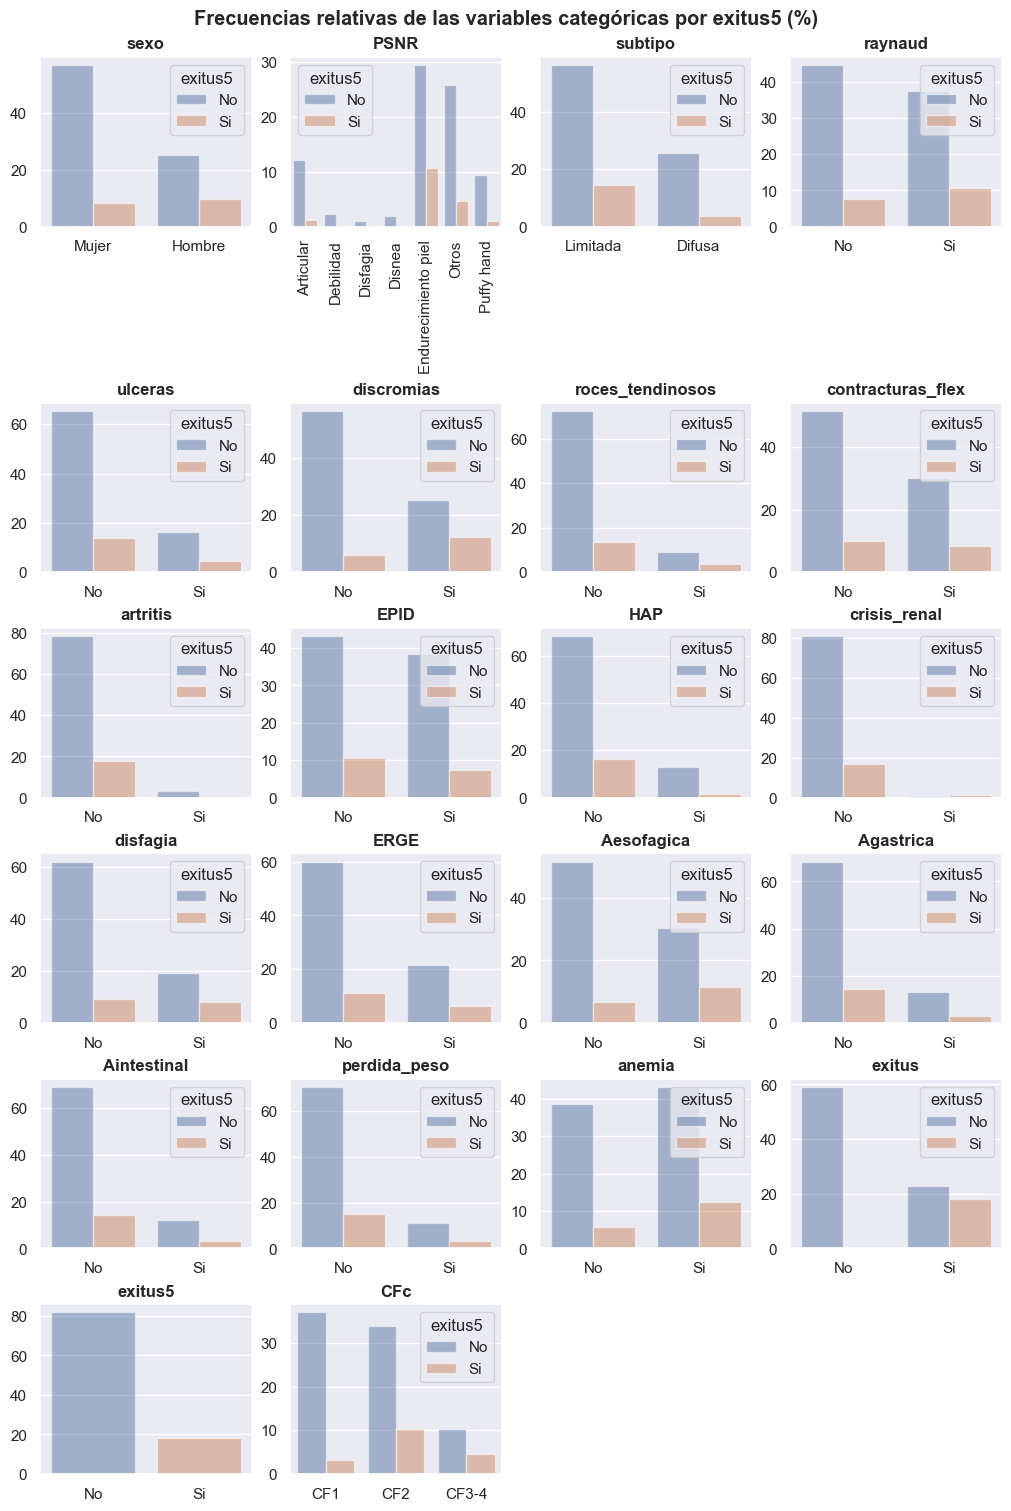

In [6]:
countplots(dfD,'exitus5')

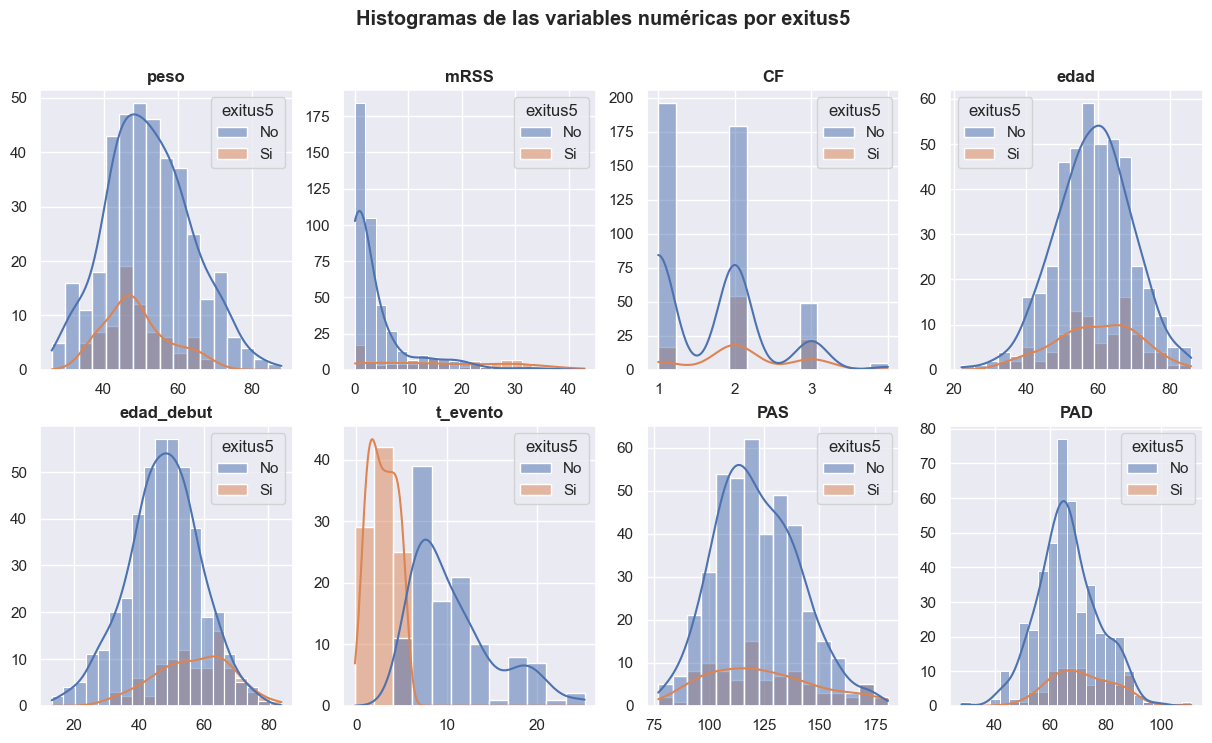

In [7]:
histograms(dfD,'exitus5')

## Estadística bivariada

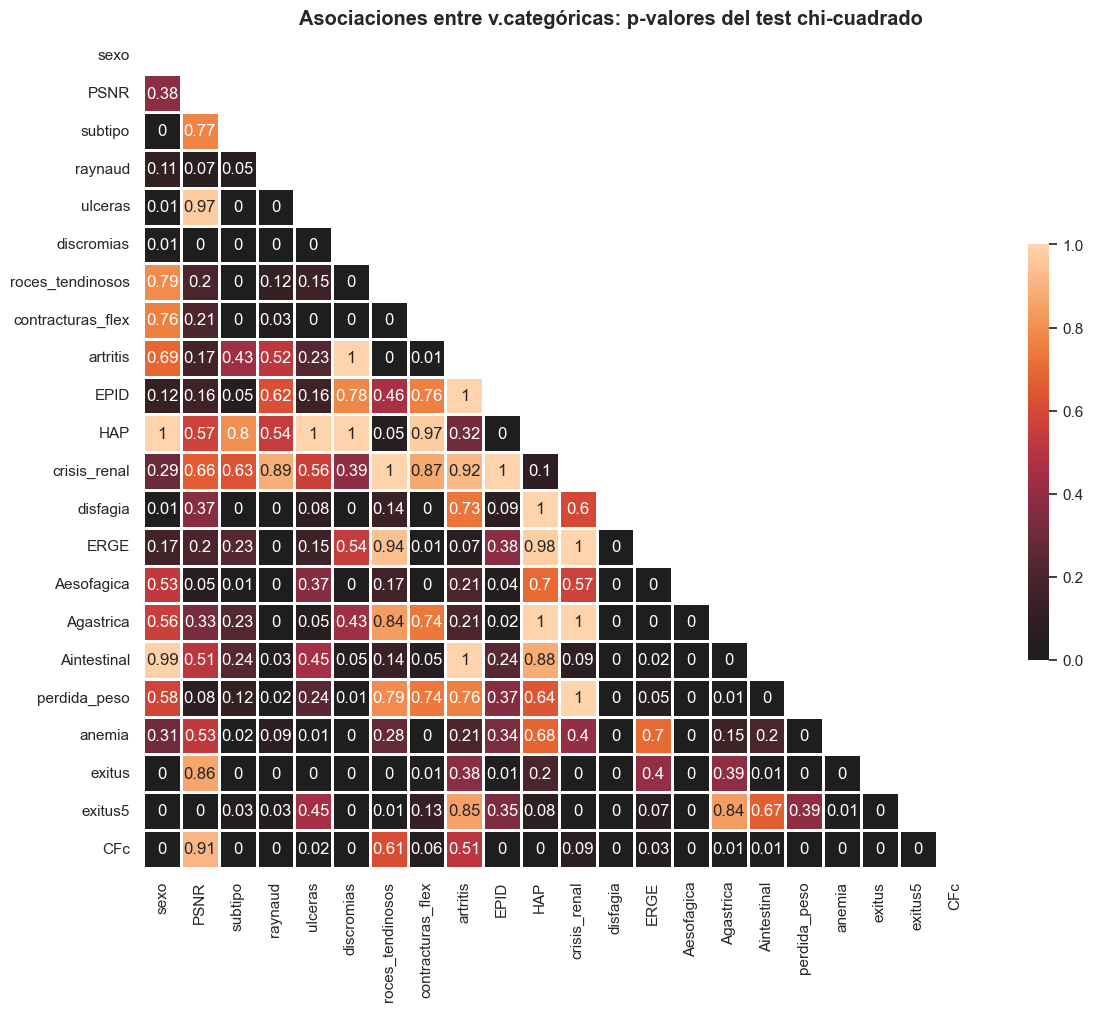

In [8]:
chi2(dfD,12,10)

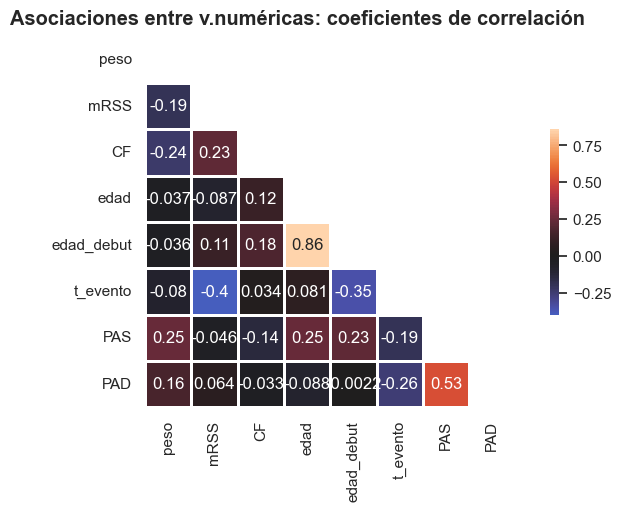

In [9]:
corr(df,8,5)

In [10]:
ttest(dfD,'exitus5','No','Si')

,ttest pval
peso,0.16
mRSS,0.00
CF,0.85
edad,0.45
edad_debut,0.00
t_evento,0.00
PAS,0.01
PAD,0.00


### Variables que explican procesos similares y codependientes

In [11]:
dfD.groupby('Aesofagica')['disfagia'].value_counts()

Aesofagica  disfagia
No          No          301
            Si            0
Si          Si          144
            No           76
Name: count, dtype: int64

In [12]:
dfD.groupby('Aesofagica')['ERGE'].value_counts()

Aesofagica  ERGE
No          No      301
            Si        0
Si          Si      146
            No       74
Name: count, dtype: int64

In [13]:
dfD.groupby('disfagia')['ERGE'].value_counts()

disfagia  ERGE
No        No      301
          Si       76
Si        No       74
          Si       70
Name: count, dtype: int64

In [14]:
dfD.groupby('raynaud')['ulceras'].value_counts()

raynaud  ulceras
No       No         249
         Si          26
Si       No         170
         Si          83
Name: count, dtype: int64

In [15]:
dfD.groupby('subtipo')['raynaud'].value_counts()

subtipo   raynaud
Limitada  Si         190
          No         184
Difusa    No          91
          Si          63
Name: count, dtype: int64

In [16]:
dfD.groupby('subtipo')['Aesofagica'].value_counts()

subtipo   Aesofagica
Limitada  No            205
          Si            169
Difusa    No            103
          Si             51
Name: count, dtype: int64

In [17]:
dfD.groupby('contracturas_flex')['mRSS'].median()

contracturas_flex
No    2.0
Si    4.0
Name: mRSS, dtype: float64

### Missings

In [43]:
dfD[dfD['exitus5']=='Si'].shape

(96, 34)

In [44]:
dfD[dfD['exitus5']=='Si'].dropna(axis=0).shape

(68, 34)

## Conclusiones

- La proporción de missings en las variables de interés no supera el 3% (excluyendo la variable peso, que al no ser importante para el análisis se eliminará)
- Descarto la imputacion de missings por cualquiera de los métodos clásicos (imputación de media, mediana, mas frecuente o no info) ya que es preferible perder una proporción pequeña de los datos. Tampoco existen suficientes variables relacionadas entre ellas para imputar con el método KNN
- La gran mayoria de variables categóricas estan desbalanceadas, incluida la variable objetivo 'exitus5'
- Las variables numericas siguen una distribución normal exceptuando:
  1. La variable mRSS: distribución muy asimetrica sesagada a la izquierda (geometrica? exponencial? lognormal?)
  2. La variable CF: es discreta y ha sido categorizada en 3 niveles (CF1, CF2, CF3-4)
  3. La variable t_evento no se incluirá en el análisis
- La multicolinealidad puede ser un problema en las variables categóricas, pero no en las numericas



### Elección del scaler adecuado

La variable mRSS es una variable a priori muy importante para el análisis, pero debido a su distribución completamente asimétrica contiene muchos valores atípicos en la cola derecha. Estos valores son importantes para el análisis, por lo que el scaler escogido debería preservar su estructura.




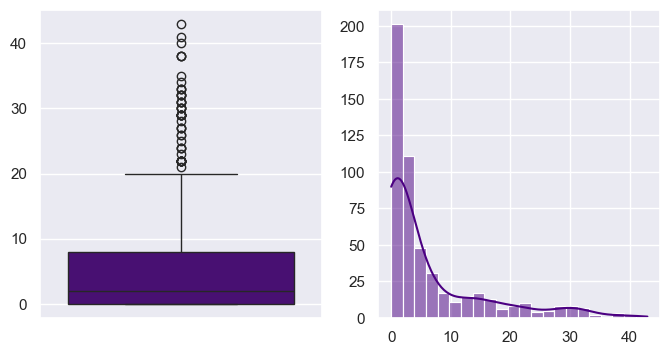

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(y="mRSS", data=dfD,color='indigo',ax=axs[0])
axs[0].set_ylabel("")
sns.histplot(df.mRSS,kde=True,color='indigo',ax=axs[1])
axs[1].set_xlabel("")
axs[1].set_ylabel("")
plt.show()

In [20]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

In [21]:
p1=pd.DataFrame(zip(df.mRSS,df.mRSS,df.mRSS),columns=['SC','RS','MMS'])

In [22]:
scalers=ColumnTransformer(
    transformers=[
        ("standard", StandardScaler(), ['SC']),
        ('robust',RobustScaler(),['RS']),
        ('minmax',MinMaxScaler(),['MMS'])],
       verbose_feature_names_out=False)

In [23]:
p1s=pd.DataFrame(scalers.fit_transform(p1),columns=scalers.get_feature_names_out())

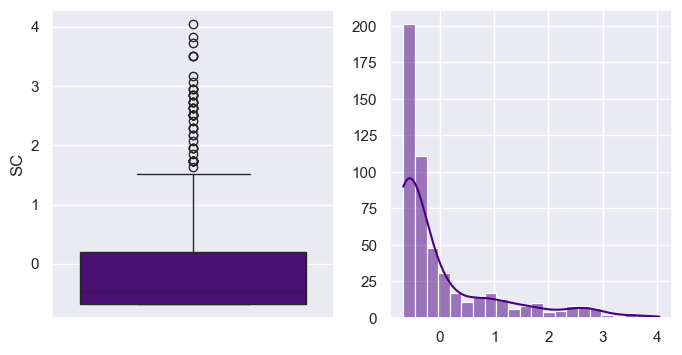

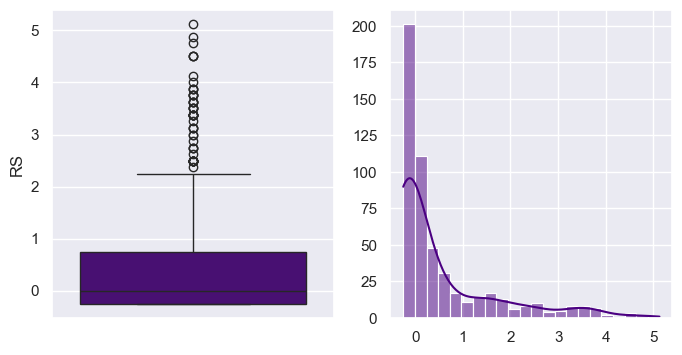

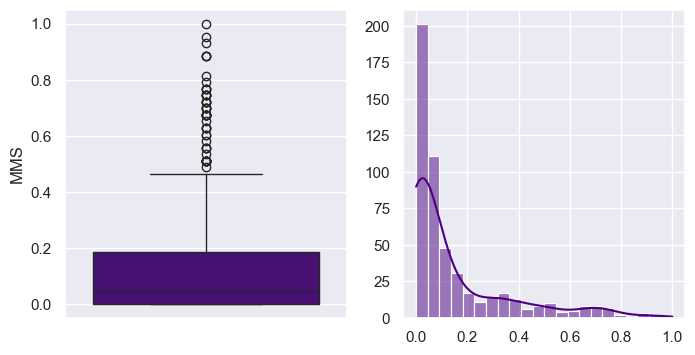

In [24]:
for i in p1s.columns:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    sns.boxplot(y=p1s[i],color='indigo',ax=axs[0])
    axs[0].set_ylabel(i)
    sns.histplot(p1s[i],kde=True,color='indigo',ax=axs[1])
    axs[1].set_xlabel("")
    axs[1].set_ylabel("")
    plt.show()

In [25]:
pprint(p1s.describe(),'',2)

,SC,RS,MMS
count,"528,00","528,00","528,00"
mean,"0,00","0,52","0,14"
std,"1,00","1,14","0,21"
min,"-0,68","-0,25","0,00"
25%,"-0,68","-0,25","0,00"
50%,"-0,46","0,00","0,05"
75%,"0,20","0,75","0,19"
max,"4,05","5,12","1,00"


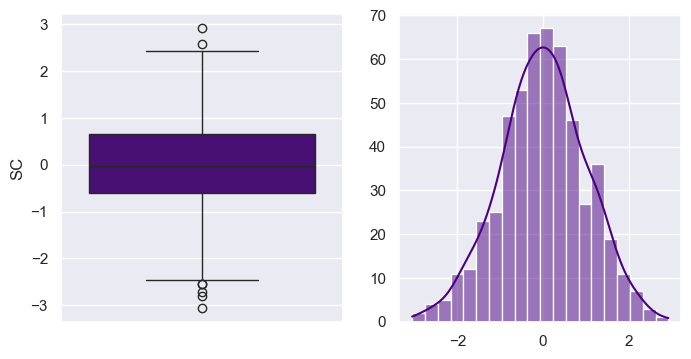

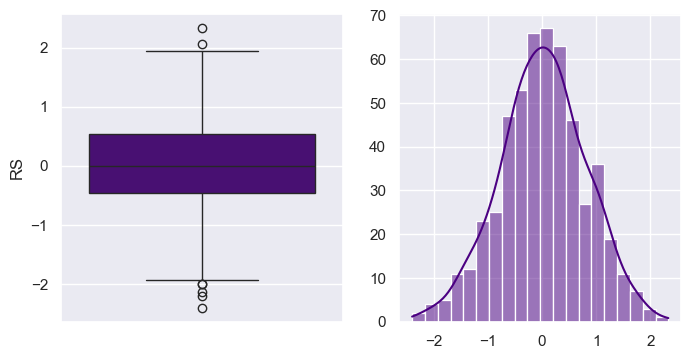

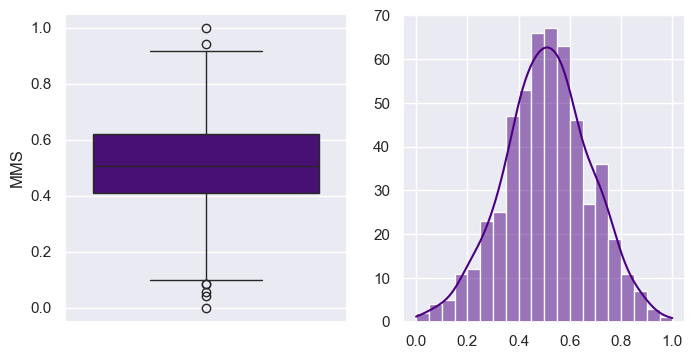

In [26]:
p2=pd.DataFrame(zip(df.edad_debut,df.edad_debut,df.edad_debut),columns=['SC','RS','MMS'])

scalers=ColumnTransformer(
    transformers=[
        ("standard", StandardScaler(), ['SC']),
        ('robust',RobustScaler(),['RS']),
        ('minmax',MinMaxScaler(),['MMS'])],
       verbose_feature_names_out=False)

p2s=pd.DataFrame(scalers.fit_transform(p2),columns=scalers.get_feature_names_out())

for i in p2s.columns:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    sns.boxplot(y=p2s[i],color='indigo',ax=axs[0])
    axs[0].set_ylabel(i)
    sns.histplot(p2s[i],kde=True,color='indigo',ax=axs[1])
    axs[1].set_xlabel("")
    axs[1].set_ylabel("")
    plt.show()